# HSQL sums and spider plots

This notebook takes as input HQSL tables generated on Notebook 10c, produces statistical data and create plots.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


In [2]:
import h3
def neighbour_mean(hex_id, hex_id_name, hex_bins, col_name):
    return hex_bins.loc[hex_bins[hex_id_name].isin(h3.k_ring(hex_id,1)),col_name].mean()

## Notebook config

In [3]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = False
# How to save?
if_exists='append'
# save to local?
save_local = True
# use local data?
local_data = False
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [4]:
walking_speed = 4.5
str_walking_speed = str(walking_speed).replace('.','_')
str_walking_speed

'4_5'

In [5]:
# Not running _priv educational equipments? Set pub = True. (ALSO VERIFY CHANGES IN PARAMETERS DICT)

In [6]:
# Output hexs resolution
res = 10
# Local dirs - 'alex' or 'edgar'
all_local_dirs = 'edgar'

## Load data

In [7]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/external/temporal_todocker/santiago/proximidad/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/santiago/"
else:
    print("WARNING: Fix all_local_dirs variable")

print(f"General directory: {grl_dir}")

General directory: ../../../data/processed/santiago/


In [8]:
area_dict = {'unidadesvecinales':'COD_UNICO_',
            'zonascensales':'GEOCODI',
            'alameda':'name',
            'comunas':'Comuna',
            'santiago':'nom_region'}

### Load data - processed HQSL data

In [9]:
hex_gdf = gpd.GeoDataFrame()

for area in area_dict.keys():
    table = f'santiago_{area}analysis_{str_walking_speed}_kmh'
    schema = 'projects_research'
    gdf_tmp = aup.gdf_from_db(table, schema)
    gdf_tmp['name'] = gdf_tmp[area_dict[area]]
    if area != 'alameda':
        gdf_tmp = gdf_tmp.drop(columns=area_dict[area])
    gdf_tmp['area_type'] = area

    hex_gdf = pd.concat([hex_gdf, gdf_tmp],
                    ignore_index = True, axis = 0)

print(hex_gdf.shape)
hex_gdf.head(2)
    

(2757, 31)


,sociability_supplying,sociability_caring,sociability_living,sociability_enjoying,sociability_learning,sociability_working,sociability,wellbeing_supplying,wellbeing_caring,wellbeing_living,...,geometry,supplying,caring,living,enjoying,learning,working,hqsl,name,area_type
0,6.781971,4.499476,5.646487,9.089797,1.949686,7.665843,35.633260,6.828092,7.539308,7.504193,...,"POLYGON ((-70.63561 -33.43567, -70.63559 -33.4...",7.165153,6.864895,6.602234,9.052305,4.314000,7.206187,41.204773,13101_1,unidadesvecinales
1,3.656250,0.359375,3.364309,1.732639,0.750000,1.987611,11.850184,3.943750,3.125000,1.450000,...,"POLYGON ((-70.67684 -33.42660, -70.67684 -33.4...",4.270833,2.811169,2.407049,1.757919,1.940972,3.701060,16.889004,13101_10,unidadesvecinales


### Load proximity data

In [10]:
hex_prox = gpd.GeoDataFrame()

for area in area_dict.keys():
    table = f'santiago_{area}variableanalysis_{str_walking_speed}_kmh'
    schema = 'projects_research'
    gdf_tmp = aup.gdf_from_db(table, schema)
    gdf_tmp['name'] = gdf_tmp[area_dict[area]]
    if area != 'alameda':
        gdf_tmp = gdf_tmp.drop(columns=area_dict[area])
    gdf_tmp['area_type'] = area

    hex_prox = pd.concat([hex_prox, gdf_tmp],
                    ignore_index = True, axis = 0)

print(hex_prox.shape)
hex_prox.head(2)

(2753, 169)


,geometry,oficinas_count,hotel_count,social_viv_count,houses_count,temp_count,inter_count,noise_count,ndvi_count,supermercado_time,...,bibliotecas_scaled,centro_edu_amb_scaled,paradas_tp_ruta_scaled,paradas_tp_metro_scaled,paradas_tp_tren_scaled,oficinas_scaled,ciclovias_scaled,estaciones_bicicletas_scaled,name,area_type
0,"POLYGON ((-70.63561 -33.43567, -70.63559 -33.4...",11.330169,6.327354,0.0,69.207206,-2.759405,59.677419,63.895028,0.205962,7.901823,...,5.72327,0.0,10.0,5.571279,0.0,7.665843,10.0,10.00000,13101_1,unidadesvecinales
1,"POLYGON ((-70.67684 -33.42660, -70.67684 -33.4...",2.245156,0.074343,0.0,71.916566,-0.026419,54.564103,62.954545,0.107118,6.870765,...,0.25000,0.0,10.0,0.062500,0.0,1.987611,10.0,0.15625,13101_10,unidadesvecinales


## Parameters dictionary

In [11]:
# --- REQUIRED DATA: parameters dictionary [AS OF 2024 06 28]
# Structure: {social_functions:{themes:[source_names]}}
parameters_dict = {'supplying':{'wellbeing':['carniceria', #Accessibility to Butcher/Fish Shops
                                             'hogar', #Accessibility to Hardware/Paint Shops
                                             #Not available: Accessibility to Greengrocers
                                             'bakeries', #Accessibility to Bakeries and delis
                                             'supermercado',#Accessibility to supermarkets
                                             'banco'#Accessibility to bank
                                            ],
                                'sociability':['ferias',#Accessibility to city fairs/markets
                                               'local_mini_market',#Accessibility to local and mini markets
                                               'correos'#ADDED: MAIL SERVICE
                                              ],
                                'environmental_impact':['centro_recyc'#Accessibility to recycling center
                                                        #Not available: Accessibility to compost
                                                       ]
                               },
                   'caring':{'wellbeing':['hospital', #Accessibility to hospital
                                          'clinica',#Accessibility to public clinics
                                          'farmacia',#Accessibility to pharmacies
                                          'vacunatorio',#Accessibility to vaccination center
                                          'consult_ado',#Accessibility to optician/audiologist(###ADDED DENTIST)
                                          'salud_mental',###ADDED: MENTAL HEALTH
                                          'labs_priv',###ADDED: LABORATORIES
                                          'residencia_adumayor'###ADDED: ELDERLY PERMANENT RESIDENCIES
                                         ],
                             'sociability':['eq_deportivo',#Accessibility to sports equipments
                                            'club_deportivo'#Accessibility to sport clubs
                                           ],
                             'environmental_impact':['noise',
                                                     'temp'
                                 #Not available: Air polution
                                                    ]
                            },
                   'living':{'wellbeing':['civic_office',#Accessibility to civic offices
                                          #Not available: Number of street bentches
                                          'tax_collection',#ADDED: AFIP(TAX COLLECTOR)
                                          'social_security',#ADDED: SOCIAL SECURITY
                                          'police',#Accessibility to police(###MOVED FROM LIVING TO CARING)
                                          'bomberos'#Accessibility to fire stations
                                          #Not available: Accessibility to street lamp
                                         ],
                             'sociability':['houses',#Accessibility to permanent residencies
                                            'social_viv',#Accessibility to social housing
                                            #Not available: Accessibility to student housing
                                            'hotel'#ADDED: HOTELS
                                           ],
                             'environmental_impact':['inter',
                                                     #Not available: Corrected compactness
                                                     #Not available: Width of sidewalks
                                                    ],
                            },
                   'enjoying':{'wellbeing':['museos',#Accessibility to museums
                                            #Not available: Accessibility to theater,operas
                                            'cines',#Accessibility to cinemas
                                            'sitios_historicos',#Accessibility to historical places
                                            'ndvi'#Number of trees
                                           ],
                               'sociability':['restaurantes_bar_cafe',#Accessibility to bars/cafes + Accessibility to restaurants
                                              'librerias',#Accessibility to record and book stores, galleries, fairs
                                              #Not available: Accessibility to cultural and/or formative spaces
                                              #Not available: Accessibility to places of workship
                                              'ep_plaza_small'#Accessibility to boulevards, linear parks, small squares + Accessibility to squares
                                             ],
                               'environmental_impact':['ep_plaza_big'#Accessibility to big parks
                                                       #Not available: Accessibility to shared gardens
                                                       #Not available: Accessibility to urban playgrounds
                                                      ]
                              },
                   'learning':{'wellbeing':['edu_basica_pub',#'edu_basica_priv',#Accessibility to public elementary school
                                            'edu_media_pub',#'edu_media_priv',#Accessibility to public high school
                                            'jardin_inf_pub',#'jardin_inf_priv',#Similar to Accessibility to childcare
                                            'universidad',#Accessibility to university
                                            'edu_tecnica',#ADDED: TECHNICAL EDUCATION
                                           ],
                               'sociability':['edu_adultos_pub',#'edu_adultos_priv',#Accessibility to adult formation centers
                                              'edu_especial_pub',#'edu_especial_priv',#Accessibility to specialized educational centers
                                              #Not available: Accesibility to establishments and services for disabled adults
                                              'bibliotecas'#Accessibility to libraries(###MOVED FROM ENJOYING TO LEARNING)
                                             ],
                               'environmental_impact':['centro_edu_amb'#Accessibility to centers for learning environmental activities
                                                       #Not available: Accessibility to gardening schools
                                                      ],
                              },
                   'working':{'wellbeing':['paradas_tp_ruta',#Accessibility to bus stop
                                           'paradas_tp_metro',#Accessibility to metro
                                           'paradas_tp_tren'#Accessibility to train stop
                                          ],
                              'sociability':['oficinas'#Accessibility to office
                                             #Not available: Accessibility to incubators
                                             #Not available: AccSeveral other articles cite 60dB as a safe noise zone. essibility to coworking places
                                          ],
                              
                              'environmental_impact':['ciclovias',
                                                      'estaciones_bicicletas'#Accessibility to bike lanes
                                                      #Not available: Accessibility to shared bike stations
                                                     ]
                             }
                  }

## __Spatial area__ analysis

### Baseline data

In [12]:
baseline = 'alameda'

hex_baseline = hex_gdf.loc[hex_gdf.name==baseline].copy()

print(hex_baseline.shape)
hex_baseline.head(2)

(1, 31)


,sociability_supplying,sociability_caring,sociability_living,sociability_enjoying,sociability_learning,sociability_working,sociability,wellbeing_supplying,wellbeing_caring,wellbeing_living,...,geometry,supplying,caring,living,enjoying,learning,working,hqsl,name,area_type
2717,7.356092,5.873093,4.326498,8.331316,2.63725,8.083957,36.608206,7.058365,7.037397,8.344592,...,"POLYGON ((-70.70775 -33.45031, -70.69297 -33.4...",7.484456,6.669088,7.131977,8.516006,4.899564,7.276711,41.977802,alameda,alameda


In [15]:
aoi_summary = hex_aoi.copy()
# Calculate mean values for area of interest
aoi_summary = aoi_summary.drop(columns=[code_column,'geometry'])
aoi_summary = aoi_summary.groupby([code_column]).mean()
aoi_summary.reset_index(inplace=True)
# Merge back to geometry
hex_new = pd.merge(aoi_all,aoi_summary,on=code_column,how = 'inner')
hex_new

NameError: name 'hex_aoi' is not defined

In [ ]:
hex_new.plot()

### __Data analysis 3__ - Polar plots

#### Libraries used for polar plots

In [13]:
import textwrap
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
import math #importing the math functions
import matplotlib.pyplot as plt

#### Functions and definitions used for polar plots

In [14]:
def wrap_labels(ax, width, rotation, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=rotation, )

def make_spider(df, row, color, title, alpha, linewidth, zorder, max_graph_value, graph_div, linestyle='solid', fill=True):
    
    categories=list(df)[0:]
    N = len(categories)

    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
     
    plt.rc('figure', figsize=(5, 5), )
 
    ax = plt.subplot(1,1,1, polar=True, )
 
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
 
   
    plt.xticks(angles[:-1], categories, color='black', size=8,zorder=10)
    ax.tick_params(axis='x', rotation=0,pad=10, zorder=10)
    # ax.set_xlabel(labelpad=10)
    
    ax.set_rlabel_position(0)
    yticks = [i for i in range(0,max_graph_value+1, graph_div)]
    yticks_lab = [str(y) for y in yticks]
    plt.yticks(yticks, yticks_lab, color="black", size=10, zorder=10)
    plt.ylim(0,max_graph_value)
     
    
    values=df.reset_index().loc[row].values.tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, color = color, linewidth=linewidth, linestyle=linestyle, marker="o")
    if fill:
        ax.fill(angles, values, color = color, alpha = alpha, zorder=zorder)
         
    wrap_labels(ax, 15, 0)
  
    # title = "Radar showing performance in each subject for "+ title
    # plt.title(title, fontsize=10, x = 0.5, y = 1.1)

pi = math.pi

## Iterate and graph

In [15]:
def social_fn_variables_graph(gdf_prox, area_name, area_type, parameters_dict, save_plot=False):
    for social_fn_graph in parameters_dict.keys():
        plt.figure()
    
        metric_list = []
    
        # Convert social function 'sf_count_15min' name to 'sf_scaledcount' name
        for val in parameters_dict[social_fn_graph].values():
            for v in val:
                metric_list.append(v+'_scaled')
    
        # Get mean values for values of interest
        gdf_polar = gdf_prox.loc[gdf_prox.name==area_name,metric_list].mean(axis=0)
    
        # Convert to df and pivot table
        df = gdf_polar.copy()
        df = pd.DataFrame(df).reset_index()
        df.index = [0]*len(df)
        df = df.rename(columns={'index':social_fn_graph, 0:'value'})
        df = df.pivot(columns=social_fn_graph, values='value')
    
        # Convert 'metric_scaledcount names' to 'metric' for plot
        for val in parameters_dict[social_fn_graph].values():
            for v in val:
                df = df.rename(columns={v+'_scaledcount':v})

        color = '#599fd5'
        # Graph
        make_spider(row=0, df = df, title = area, 
                    color = color, alpha=0.5, linewidth=1, zorder=-1,
                    max_graph_value = 10, graph_div = 2)
    
        # Save
        if save_plot:
            plt.savefig(f'../../../output/figures/santiago/polar_plots/{str_walking_speed}_{area_type}/Social_Fn/SocialFunctions_{area_name}_{social_fn_graph}.svg')

In [20]:
def hqsl_graph(gdf, area_name, area_type, baseline_gdf, save_plot=False):
    df, df_baseline = create_graph_df(gdf, area_name, area_type, baseline_gdf)
    create_spider_graph(df, df_baseline, area_name, area_type, save_plot=save_plot)

def create_graph_df(gdf, area_name, area_type, baseline_gdf):
    summary_cols = ['supplying','caring','living',
               'enjoying','learning','working']
    gdf_polar = gdf[summary_cols].mean(axis=0)
    gdf_baseline = baseline_gdf[summary_cols].mean(axis=0)

    # Convert to df and pivot table
    df = gdf_polar.copy()
    df = pd.DataFrame(df).reset_index()
    df.index = [0]*len(df)
    df = df.rename(columns={'index':'social_fn',0:'value'})
    df = df.pivot(columns='social_fn', values='value')
    # baseline data
    df_baseline = gdf_baseline.copy()
    df_baseline = pd.DataFrame(df_baseline).reset_index()
    df_baseline.index = [0]*len(df_baseline)
    df_baseline = df_baseline.rename(columns={'index':'social_fn',0:'value'})
    df_baseline = df_baseline.pivot(columns='social_fn', values='value')
    
    return df, df_baseline

def create_spider_graph(df, df_baseline, area_name, area_type, save_plot=False):
    plt.figure()
    # Convert 'sf_scaledcount names' to 'sf' for plot
    df = df.rename(columns={'caring':'Caring',
                           'working':'Working',
                           'enjoying':'Enjoying',
                           'supplying':'Supplying',
                            'living':'Living',
                            'learning':'Learning'})
    
    df_baseline = df_baseline.rename(columns={'caring':'Caring',
                           'working':'Working',
                           'enjoying':'Enjoying',
                           'supplying':'Supplying',
                            'living':'Living',
                            'learning':'Learning'})
    # Graph
    color = '#599fd5'
    make_spider(row=0, df = df, title = area_name, 
                color = color, alpha=0.5, linewidth=1, zorder=-1,
                max_graph_value = 10, graph_div = 2)
    
    
    color = '#090e19'
    make_spider(row=0, df = df_baseline, title = 'Alameda', 
                color = color, alpha=0.5, linewidth=1, zorder=-1,
                max_graph_value = 10, graph_div = 2, linestyle='dashed', fill=False)
    
    # Save
    if save_plot:
        plt.savefig(f'../../../output/figures/santiago/polar_plots/{str_walking_speed}_{area_type}/SocialFunctions_{area_name}.svg')


In [17]:
def indicator_graph(gdf, area_name,area_type, save_plot=False):
    summary_cols = ['wellbeing','sociability','environmental_impact']
    gdf_polar =  gdf[summary_cols].mean(axis=0)
    # Convert to df and pivot table
    df = gdf_polar.copy()
    df = pd.DataFrame(df).reset_index()
    df.index = [0]*len(df)
    df = df.rename(columns={'index':'indicator',0:'value'})
    df = df.pivot(columns='indicator', values='value')

    plt.figure()
    sns.barplot(df)
    if save_plot:
        plt.savefig(f'../../../output/figures/santiago/polar_plots/{str_walking_speed}_{area_type}/Indicators_{area_name}.svg')

In [18]:
hex_gdf.loc[hex_gdf.area_type=='santiago']

,sociability_supplying,sociability_caring,sociability_living,sociability_enjoying,sociability_learning,sociability_working,sociability,wellbeing_supplying,wellbeing_caring,wellbeing_living,...,geometry,supplying,caring,living,enjoying,learning,working,hqsl,name,area_type
2756,3.908312,4.761166,3.996647,4.952238,1.534072,0.859611,20.012047,2.739461,2.360851,2.108491,...,"POLYGON ((-70.80625 -33.58906, -70.80626 -33.5...",3.397471,3.331469,3.387685,4.059002,2.54909,2.951448,19.676166,Metropolitana de Santiago,santiago


Finished plotting santiago : Metropolitana de Santiago


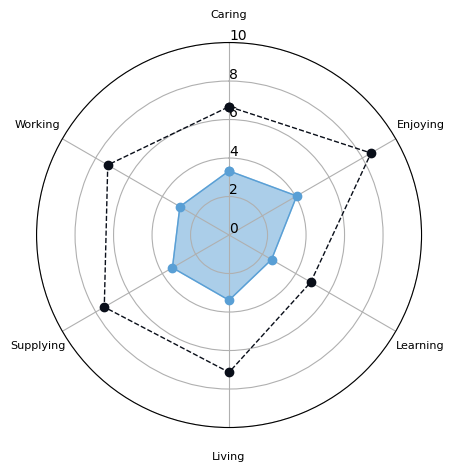

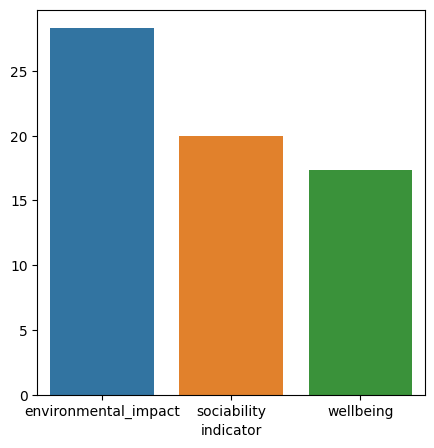

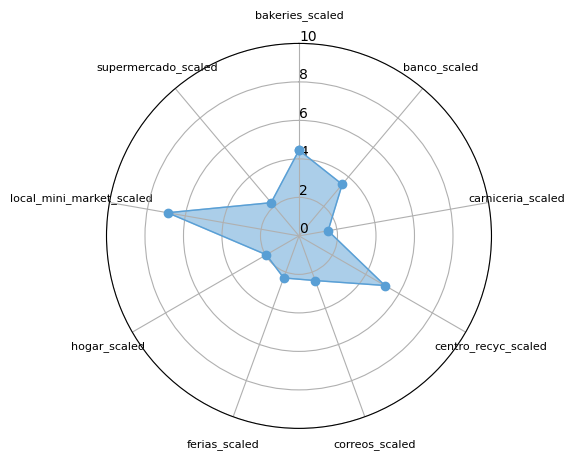

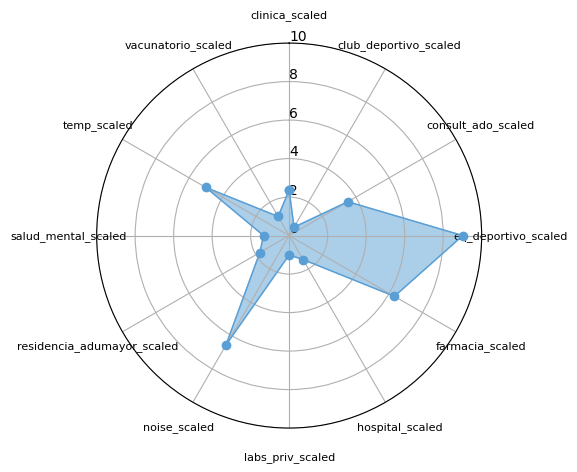

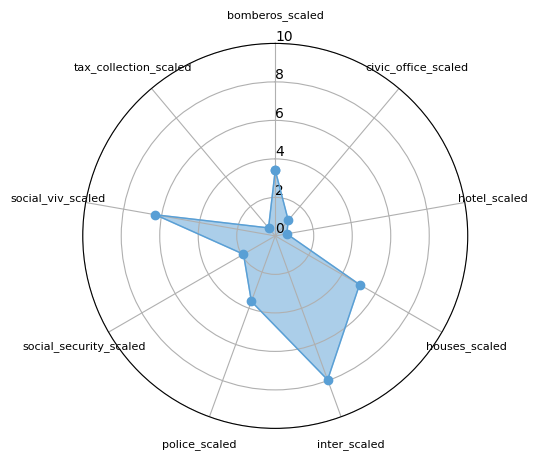

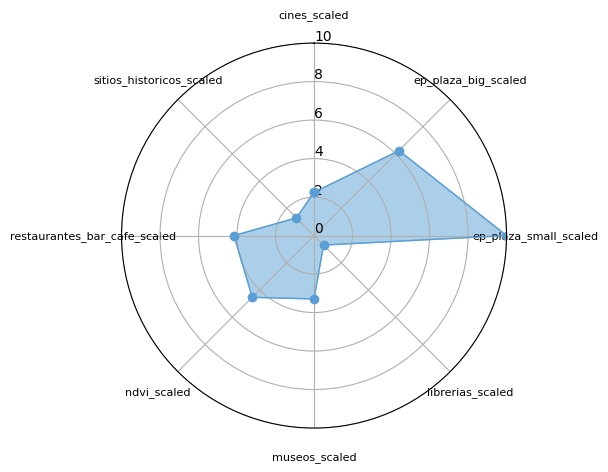

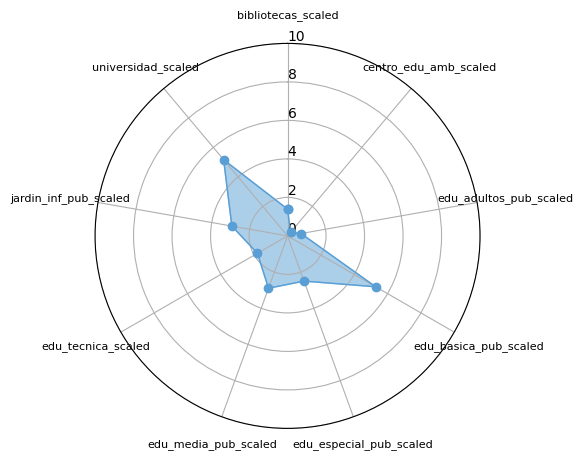

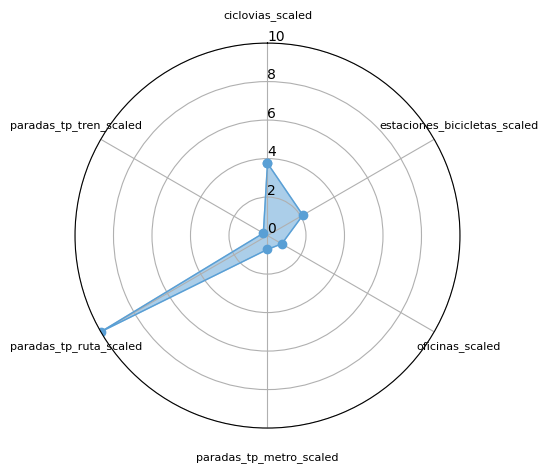

In [22]:
# if area='Unidades vecinales', CHOOSE UNIDAD VECINAL HERE.
# else, chosen unidad_vecinal doesn't matter.
# unidades vecinales: ['13123_14','13101_49','13101_18','13101_13','13106_22','13106_12',
#              '13106_06','13106_18','13106_17','13101_3']
save_plot = True
code_column = 'name'

plot_dict = {'unidadesvecinales':['13101_15','13101_18','13101_3',
                                 '13101_49','13106_08','13106_11_A',
                                 '13106_17','13117_19','13123_14'],
            'alameda':['alameda','alameda_poniente','alameda_oriente'],
            'comunas': ['Pedro Aguirre Cerda',
                       'Providencia','Las Condes',
                       'Quilicura','La Florida'],
            'santiago':['Metropolitana de Santiago']} # Area Urbana La Florida, Area Urbana Las Condes, Providencia, Pedro Aguirre Cerda, Area Urbana Quilicura

plot_dict = {'santiago':['Metropolitana de Santiago']} 

for area_type in plot_dict.keys():
    for area_name in plot_dict[area_type]:

        gdf = hex_gdf.loc[hex_gdf[code_column]==area_name].copy()

        hqsl_graph(gdf, area_name, area_type, hex_baseline, save_plot=save_plot)
        
        indicator_graph(gdf, area_name, area_type, save_plot=save_plot)
        
        social_fn_variables_graph(hex_prox, area_name, area_type, parameters_dict, save_plot=save_plot)

        print('Finished plotting',area_type,':',area_name)


### Export indicator table

In [23]:
hex_gdf[['environmental_impact','sociability','wellbeing','name','area_type']].to_csv('../../../output/data/santiago/indicators_by_area.csv')